# Online Retail Project

Within this notebook, I'll be clustering the customers of an online retailer based on their 1yr historical purchase history.

2nd part of the project will also include a sales predictor

Data has been downloaded from the UC Irvine Machine Learning Repository

### Attribute Information:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated. 
- UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal, the name of the country where each customer resides.



In [1]:
# First Import work
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')  # set the plotting style to ggplot
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import datetime as dt
from scipy.stats import skew
from scipy import stats
import pprint
import re
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve

In [2]:
df = pd.read_csv('data.csv', encoding = "ISO-8859-1")

In [3]:
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
176274,551997,84949,SILVER HANGING T-LIGHT HOLDER,1,5/5/2011 15:47,3.29,NaN,United Kingdom
3245,536613,21918,SET 12 KIDS COLOUR CHALK STICKS,24,12/2/2010 9:44,0.42,17855.0,United Kingdom
517008,580025,20727,LUNCH BAG BLACK SKULL.,1,12/1/2011 11:53,1.65,15021.0,United Kingdom
330403,565918,23427,STOOL HOME SWEET HOME,1,9/7/2011 16:27,12.50,13249.0,United Kingdom
297345,562936,22438,BALLOON ART MAKE YOUR OWN FLOWERS,1,8/10/2011 17:12,1.95,NaN,United Kingdom
223050,556471,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,6/12/2011 11:47,2.95,16466.0,United Kingdom
426955,573371,23275,SET OF 3 HANGING OWLS OLLIE BEAK,12,10/30/2011 13:34,1.25,13113.0,United Kingdom
364248,568654,72819,CUPID DESIGN SCENTED CANDLES,12,9/28/2011 12:20,2.55,14911.0,EIRE
167537,550993,23207,LUNCH BAG ALPHABET DESIGN,10,4/21/2011 19:51,1.65,15810.0,United Kingdom
314464,564639,85099C,JUMBO BAG BAROQUE BLACK WHITE,6,8/26/2011 12:55,2.08,18036.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# Customer ID needs to be categorical

df['CustomerID'] = df['CustomerID'].astype(object)

In [8]:
# Drop rows that has NaN CustomerID

df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)


In [9]:
# Check & drop duplicate data

df.drop_duplicates(inplace = True)

In [10]:
def missing_values_table(df):
    '''
    Function to calculate missing values by column

    INPUT:
        dataframe

    OUTPUT:
        table of missing data & percentages

    '''
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values_table(df)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Finally we have a dataframe with no missing data

#### Summary of counts per products/transactions/customers

In [11]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


Unique elements in products, transactions and customers

### Feature Engineering

In [12]:
# dropping rows where a customer ID does not exist

df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [13]:
# Convert invoice date column to datetime object

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [14]:
# # Extract time information from the invoicedate

df['day'] = df['InvoiceDate'].dt.day.astype(object)
df['month'] = df['InvoiceDate'].dt.month.astype(object)
df['date'] = df['InvoiceDate'].dt.date.astype(object)
df['Time'] = df['InvoiceDate'].dt.time.astype(object)

# Remove InvoiceDate column
df.drop(['InvoiceDate'], axis=1, inplace=True)

In [15]:
# Stock codes include special stock codes which are not part of sales.. We'll need to handle these

stock_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
stock_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [16]:
# Create a bool column for cancelled orders

def return_func(x):
    '''
    Creates a new bool column for returns
    
    INPUT:
        Column to use for the bool 0 or 1
    
    OUTPUT:
        New column with either 1 for returned/cancelled 
        or 0 for non-returned/cancelled
    '''
    
    if x < 0:
        x = 1
    else:
        x = 0
    return x

df['Cancelled'] = df['Quantity'].apply(return_func)     

In [17]:
# Invoice No & Stock Code columns include strings embedded -
# into numbers/codes. We're going to strip those out

df['Invoice_No'] = df['InvoiceNo'].apply(
    lambda x: re.findall(r'\d+', str(x))).apply(lambda x: pd.Series(x))

df['Stock_Code'] = df['StockCode'].apply(
    lambda x: re.findall(r'\d+', str(x))).apply(lambda x: pd.Series(x))

# Remove old InvoiceNo & StockCode columns
df.drop(['InvoiceNo'], axis = 1, inplace = True)
df.drop(['StockCode'], axis = 1, inplace = True)


In [18]:
df['CustomerID'].fillna(0, inplace=True)


In [19]:
# Removing rows which has a negative unit price - aka bad debt
# Removing rows which doesn't have a product description

df = df[df['UnitPrice'] > 0]
df = df[df['Description'].isnull() == False]


In [20]:
# Remaining df shape

df.shape

(401564, 12)

In [21]:
# Investigating the Country column

df['Country'].value_counts()

United Kingdom          356704
Germany                   9478
France                    8474
EIRE                      7473
Spain                     2527
Netherlands               2367
Belgium                   2069
Switzerland               1876
Portugal                  1471
Australia                 1255
Norway                    1085
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     247
Unspecified                241
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         57
Lebanon                     45
Lithuani

In [22]:
# Fixing the country names to real country names

df.loc[df['Country'] == 'EIRE', 'Country'] = 'Ireland'
df.loc[df['Country'] == 'RSA', 'Country'] = 'South Africa'
df.loc[df['Country'] == 'USA', 'Country'] = 'United States'
df.loc[df['Country'] == 'European Community', 'Country'] = 'France'
df.loc[df['Country'] == 'Channel Islands', 'Country'] = 'United States'
df.loc[df['Country'] == 'Unspecified', 'Country'] = 'United Kingdom'

### Recency, Frequency, and Monetary (RFM) Segmentation


RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

RFM stands for the three dimensions:

- Recency – How recently did the customer purchase?
- Frequency – How often do they purchase?
- Monetary Value – How much do they spend?

RFM factors illustrate these facts:

- the more recent the purchase, the more responsive the customer is to promotions
- the more frequently the customer buys, the more engaged and satisfied they are
- monetary value differentiates heavy spenders from low-value purchasers

In [23]:
df.sample(3)

,Description,Quantity,UnitPrice,CustomerID,Country,day,month,date,Time,Cancelled,Invoice_No,Stock_Code
202112,RED RETROSPOT OVEN GLOVE,10,1.25,12647.0,Germany,24,5,2011-05-24,10:19:00,0,554363,21154
416868,HOT WATER BOTTLE KEEP CALM,4,4.95,13481.0,United Kingdom,25,10,2011-10-25,09:07:00,0,572562,23355
188854,RED VICTORIAN FABRIC OVAL BOX,6,0.42,16871.0,United Kingdom,13,5,2011-05-13,11:44:00,0,553067,35095


In [24]:
# Earliest & Recent Dates

earliest_date = df.drop_duplicates(['Invoice_No']).groupby('CustomerID')[['date']].min().reset_index()
earliest_date.columns = ['CustomerID', 'earliest_date']

recent_date = df.drop_duplicates(['Invoice_No']).groupby('CustomerID')[['date']].max().reset_index()
recent_date.columns = ['CustomerID', 'recent_date']

df = pd.merge(df, earliest_date, how = 'left', on = 'CustomerID')
df = pd.merge(df, recent_date, how = 'left', on = 'CustomerID')

In [25]:
# Total item cost in the invoice

df['item_total_cost'] = df['Quantity'] * df['UnitPrice']

# Total Revenue from the customer

df['total_revenue'] = df.groupby('Invoice_No', sort=False)['item_total_cost'].transform('sum')


In [26]:
# Average transaction per customer

avg_cust = df.drop_duplicates(['Invoice_No']).groupby('CustomerID')[['total_revenue']].mean().reset_index()
avg_cust['CustomerID'] = avg_cust['CustomerID'].astype(int)
avg_cust.columns = ['CustomerID', 'avg_transaction']

df = pd.merge(df, avg_cust, how = 'left', on = 'CustomerID',)
df['avg_transaction'] = df['avg_transaction'].astype(float)

In [27]:
# Frequency

freq_cust = df.drop_duplicates(['Invoice_No']).groupby('CustomerID')[['total_revenue']].count().reset_index()
freq_cust['CustomerID'] = freq_cust['CustomerID'].astype(int)
freq_cust.columns = ['CustomerID', 'frequency']

df = pd.merge(df, freq_cust, how = 'left', on = 'CustomerID',)

In [28]:
# Recency

earliest_date = df['date'].min()
end_date = df['date'].max()
snapshot_date = end_date + dt.timedelta(days=1)

df_recency = df.groupby(['CustomerID']).agg({'recent_date': lambda x: (snapshot_date - x.max()).days}).reset_index()
df_recency['CustomerID'] = df_recency['CustomerID'].astype(int)
df_recency.columns = ['CustomerID', 'recency']

df = pd.merge(df, df_recency, how = 'left', on = 'CustomerID',)

#### RFM Segments

In [29]:
# Copy the original to new df

df_rfm = df.copy()

In [30]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [31]:
# RFM table

df_rfm = df_rfm.groupby(['CustomerID']).agg({
    'date': lambda x: (snapshot_date - x.max()).days,
    'Invoice_No': 'count',
    'item_total_cost': 'sum'
})

In [32]:
df_rfm.head(5)

,date,Invoice_No,item_total_cost
CustomerID,,,
12346.00,326,2,0.00
12347.00,3,182,4310.00
12348.00,76,31,1797.24
12349.00,19,73,1757.55
12350.00,311,17,334.40


In [33]:
# Rename the columns
df_rfm.rename(columns={'date': 'Recency', 
                       'Invoice_No': 'Frequency',
                       'item_total_cost': 'Revenue'}, inplace=True)
# Print top 5 rows
print(df_rfm.head())

            Recency  Frequency  Revenue
CustomerID                             
12346.00        326          2     0.00
12347.00          3        182  4310.00
12348.00         76         31  1797.24
12349.00         19         73  1757.55
12350.00        311         17   334.40


#### RFM Segmentation

In [34]:
def rfm_segment(df, column, start_segment, end_segment, step = 1):
    category_label = range(start_segment, end_segment, step)
    segment = pd.qcut(df[column], q = abs(end_segment - start_segment),
                     labels = category_label)
    df = df.assign(name = segment.values)
    new_column_name = column + '_S'
    return df.rename(columns = {'name': new_column_name})

In [35]:
df_rfm_segmented = df_rfm.copy()

In [36]:
df_rfm_segmented = rfm_segment(df_rfm_segmented, 'Recency', 4, 0, -1)
df_rfm_segmented = rfm_segment(df_rfm_segmented, 'Frequency', 1, 5)
df_rfm_segmented = rfm_segment(df_rfm_segmented, 'Revenue' , 1, 5)
df_rfm_segmented.sample(5)

,Recency,Frequency,Revenue,Recency_S,Frequency_S,Revenue_S
CustomerID,,,,,,
12523.00,2,110,1745.57,4,4,4
17878.00,44,26,379.45,3,2,2
16000.00,3,9,12393.70,4,1,4
13717.00,33,103,1432.26,3,4,3
17930.00,36,39,1740.48,3,2,4


#### RFM Score

In [37]:
# Concatenate RFM quartile values

def join_rfm(x):
    return str(x['Recency_S']) + str(x['Frequency_S']) + str(x['Revenue_S'])


In [38]:
df_rfm_segmented['RFM_segment'] = df_rfm_segmented.apply(join_rfm, axis = 1)

In [39]:
df_rfm_segmented['RFM_score'] = df_rfm_segmented[['Recency_S', 
                              'Frequency_S', 
                              'Revenue_S']].sum(axis = 1)

In [40]:
df_rfm_segmented.head(5)

,Recency,Frequency,Revenue,Recency_S,Frequency_S,Revenue_S,RFM_segment,RFM_score
CustomerID,,,,,,,,
12346.00,326,2,0.00,1,1,1,111,3.00
12347.00,3,182,4310.00,4,4,4,444,12.00
12348.00,76,31,1797.24,2,2,4,224,8.00
12349.00,19,73,1757.55,3,3,4,334,10.00
12350.00,311,17,334.40,1,1,2,112,4.00


#### Customer Segments

In [41]:
def cust_segments(df):
    '''
    Assigns RFM Scores to each customer.
        Segments: 
        1 is the high priority customers, 
        3 is low priority customers
    INPUT:
        dataframe
    OUTPUT:
        new column with RFM scores
    '''
    if df['RFM_score'] >= 9:
        return '1'
    elif (df['RFM_score'] >= 5 and (df['RFM_score'] < 9)):
        return '2'
    else:
        return '3'

In [42]:
df_rfm_segmented['Segment'] = df_rfm_segmented.apply(cust_segments, axis = 1)

In [43]:
df_rfm_segmented.head(4)

,Recency,Frequency,Revenue,Recency_S,Frequency_S,Revenue_S,RFM_segment,RFM_score,Segment
CustomerID,,,,,,,,,
12346.00,326,2,0.00,1,1,1,111,3.00,3
12347.00,3,182,4310.00,4,4,4,444,12.00,1
12348.00,76,31,1797.24,2,2,4,224,8.00,2
12349.00,19,73,1757.55,3,3,4,334,10.00,1


### Skewness

K-Means assume symmertical distribution of varibles and variables have equal average value and std.
- If the distribution is not symmetrical
    - Log transformation (if all values are positive)
    - Add the absolute value of the lowest negative value to each observation, and then with a small constant (e.g. 1) to force all variables to be positive
    - Use a cube root transformation
- If the mean and variables are not equal, the variables could be standardised

In [44]:
df_rfm.columns

Index(['Recency', 'Frequency', 'Revenue'], dtype='object')

In [45]:
def check_skew(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column]) 
    plt.title('Skewness of ' + column) 
    sns.distplot(df[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest
    ))
    return

<Figure size 648x648 with 0 Axes>

Recency's: Skew: 1.2486282855457034, : SkewtestResult(statistic=26.75197937773863, pvalue=1.1710104639780896e-157)


Frequency's: Skew: 18.08774638299986, : SkewtestResult(statistic=83.86050983036526, pvalue=0.0)


Revenue's: Skew: 21.695095187437193, : SkewtestResult(statistic=87.88184887191, pvalue=0.0)


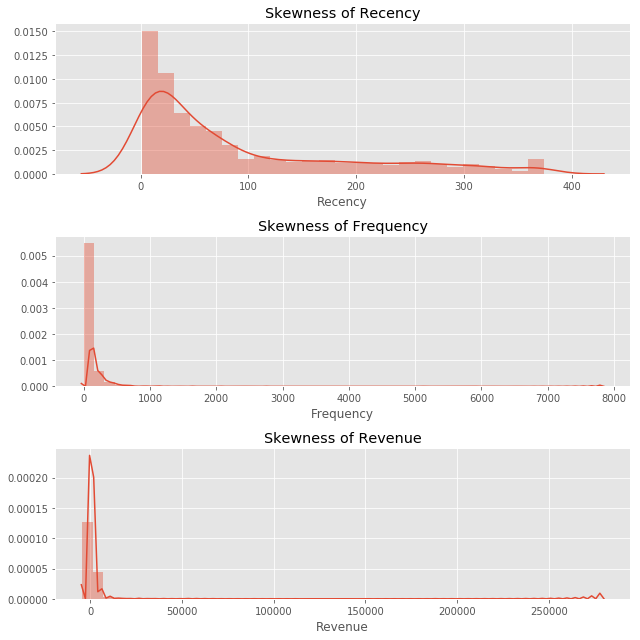

In [46]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1) 
check_skew(df_rfm,'Recency')

plt.subplot(3, 1, 2) 
check_skew(df_rfm,'Frequency')

plt.subplot(3, 1, 3) 
check_skew(df_rfm,'Revenue')

plt.tight_layout()

In [47]:
df_rfm.describe()

,Recency,Frequency,Revenue
count,4371.00,4371.00,4371.00
mean,92.60,91.87,1893.96
std,100.78,229.22,8219.59
min,1.00,1.00,-4287.63
25%,17.00,17.00,291.94
50%,51.00,41.00,644.24
75%,144.00,99.50,1608.94
max,374.00,7812.00,279489.02


In [48]:
df_new = df_rfm.copy()

In [49]:
# Handling the Negative Value
df_new['Revenue'] = (df_new['Revenue'] - df_new['Revenue'].min()) + 1

In [50]:
df_new = np.log(df_new)

<Figure size 648x648 with 0 Axes>

Recency's: Skew: -0.44735340330958573, : SkewtestResult(statistic=-11.561929048089798, pvalue=6.424902763844789e-31)


Frequency's: Skew: -0.24287213230457516, : SkewtestResult(statistic=-6.473789538711095, pvalue=9.557500375596968e-11)


Revenue's: Skew: 0.26892996507448774, : SkewtestResult(statistic=7.146201795814777, pvalue=8.921188578529382e-13)


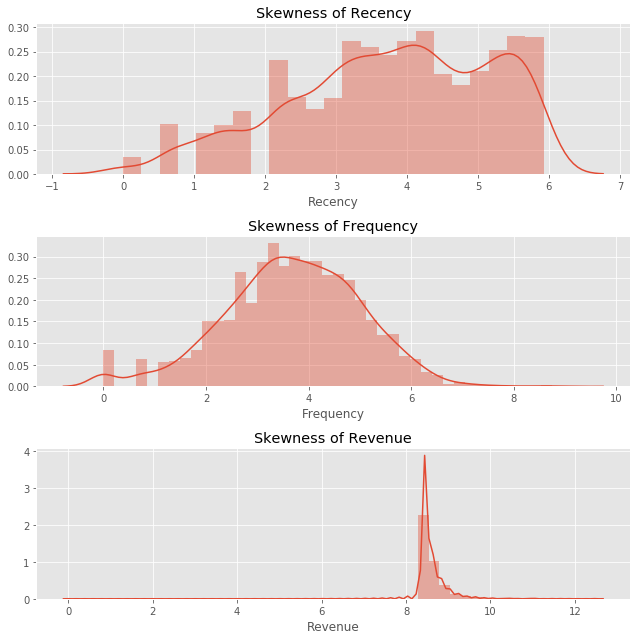

In [51]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1) 
check_skew(df_new,'Recency')

plt.subplot(3, 1, 2) 
check_skew(df_new,'Frequency')

plt.subplot(3, 1, 3) 
check_skew(df_new,'Revenue')

plt.tight_layout()

In [52]:
df_normalized = df_new.copy()

In [53]:
# StandardScaler of data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_normalized)
df_normalized = scaler.transform(df_normalized)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [54]:
df_normalized = pd.DataFrame(df_normalized, index = df_new.index,
columns = df_new.columns)

In [55]:
df_normalized.head(5)

,Recency,Frequency,Revenue
CustomerID,,,
12346.00,1.43,-2.23,-0.69
12347.00,-1.89,1.14,1.22
12348.00,0.40,-0.18,0.27
12349.00,-0.58,0.46,0.25
12350.00,1.40,-0.63,-0.49


In [56]:
df_normalized.describe()

,Recency,Frequency,Revenue
count,4371.00,4371.00,4371.00
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-2.67,-2.75,-23.69
25%,-0.66,-0.63,-0.51
50%,0.12,0.03,-0.31
75%,0.85,0.69,0.18
max,1.53,3.96,10.83


# Clustering using KMeans - Silhouette Score

In [57]:
def optimal_kmeans(dataset, start=2, end=11):
    '''
    Calculate the optimal number of kmeans
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit
        start : int. Starting range of kmeans to test
        end : int. Ending range of kmeans to test
    OUTPUT:
        Values and line plot of Silhouette Score.
    '''
    
    # Create empty lists to store values for plotting graphs
    n_clu = []
    km_ss = []

    # Create a for loop to find optimal n_clusters
    for n_clusters in range(start, end):

        # Create cluster labels
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(dataset)

        # Calcualte model performance
        silhouette_avg = round(silhouette_score(dataset, labels, random_state=1), 3)

        # Append score to lists
        km_ss.append(silhouette_avg)
        n_clu.append(n_clusters)

        print("No. Clusters: {}, Silhouette Score: {}, Change from Previous Cluster: {}".format(
            n_clusters, 
            silhouette_avg, 
            (km_ss[n_clusters - start] - km_ss[n_clusters - start - 1]).round(3)))

        # Plot graph at the end of loop
        if n_clusters == end - 1:
            plt.figure(figsize=(6.47,4))

            plt.title('Silhouette Score of Different Number of Clusters')
            plt.ylabel('Silhouette Score')
            plt.xlabel('Number of Clusters')
            sns.pointplot(x=n_clu, y=km_ss)
            plt.savefig('silhouette_score.png', format='png', dpi=1000)
            plt.tight_layout()
            plt.show()

No. Clusters: 2, Silhouette Score: 0.397, Change from Previous Cluster: 0.0
No. Clusters: 3, Silhouette Score: 0.351, Change from Previous Cluster: -0.046
No. Clusters: 4, Silhouette Score: 0.301, Change from Previous Cluster: -0.05
No. Clusters: 5, Silhouette Score: 0.3, Change from Previous Cluster: -0.001
No. Clusters: 6, Silhouette Score: 0.295, Change from Previous Cluster: -0.005
No. Clusters: 7, Silhouette Score: 0.296, Change from Previous Cluster: 0.001
No. Clusters: 8, Silhouette Score: 0.31, Change from Previous Cluster: 0.014
No. Clusters: 9, Silhouette Score: 0.3, Change from Previous Cluster: -0.01
No. Clusters: 10, Silhouette Score: 0.303, Change from Previous Cluster: 0.003


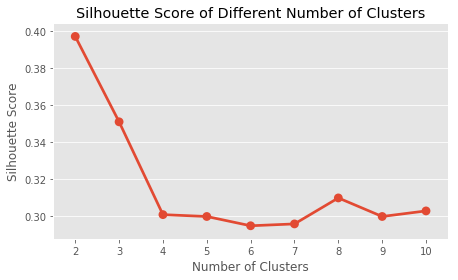

In [58]:
optimal_kmeans(df_normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=30, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, '4 Clusters Visualization')

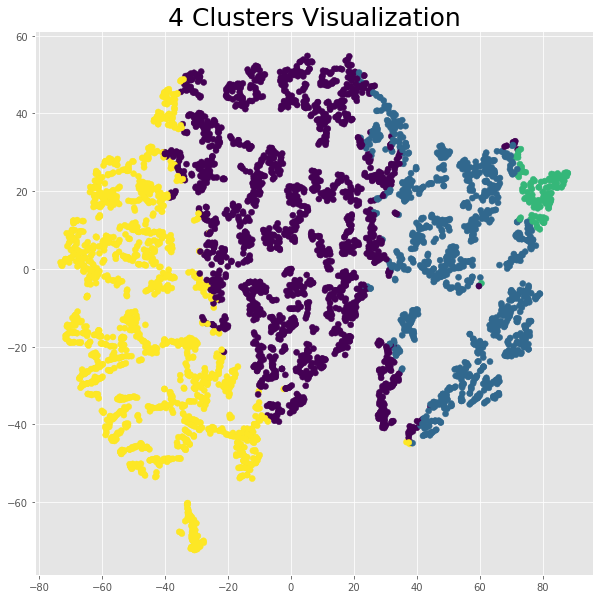

In [59]:
from sklearn.manifold import TSNE

kmeans = KMeans(init='k-means++', n_clusters = 4, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(df_normalized)
clusters = kmeans.predict(df_normalized)

tsne = TSNE(n_components=2)
proj = tsne.fit_transform(df_normalized)

import matplotlib.cm as cm

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("4 Clusters Visualization", fontsize="25")


In [60]:
df_normalized['cluster'] = clusters

In [61]:
df_normalized = df_normalized.reset_index()

In [62]:
final_df = df_normalized.copy()

In [63]:
df.columns

Index(['Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country', 'day',
       'month', 'date', 'Time', 'Cancelled', 'Invoice_No', 'Stock_Code',
       'earliest_date', 'recent_date', 'item_total_cost', 'total_revenue',
       'avg_transaction', 'frequency', 'recency'],
      dtype='object')

### Checking the clusters

In [64]:
cust0 = list(final_df[final_df['cluster']==0]['CustomerID'])
cluster0 = df[df['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'Cancelled', 'avg_transaction',
          'total_revenue', 'frequency','recency']].mean()
cluster0['Description'].value_counts()[:10]

Quantity            9.33
UnitPrice           3.15
Cancelled           0.02
avg_transaction   349.86
total_revenue     453.07
frequency           4.30
recency            78.74
dtype: float64

WHITE HANGING HEART T-LIGHT HOLDER    664
REGENCY CAKESTAND 3 TIER              557
ASSORTED COLOUR BIRD ORNAMENT         487
PARTY BUNTING                         421
SET OF 3 CAKE TINS PANTRY DESIGN      386
JUMBO BAG RED RETROSPOT               366
REX CASH+CARRY JUMBO SHOPPER          330
POSTAGE                               325
NATURAL SLATE HEART CHALKBOARD        320
JAM MAKING SET WITH JARS              317
Name: Description, dtype: int64

In [65]:
cust1 = list(final_df[final_df['cluster']==1]['CustomerID'])
cluster1 = df[df['CustomerID'].isin(cust1)]
cluster1[['Quantity', 'UnitPrice', 'Cancelled', 'avg_transaction',
          'total_revenue', 'frequency','recency']].mean()
cluster1['Description'].value_counts()[:10]

Quantity            8.78
UnitPrice           3.05
Cancelled           0.02
avg_transaction   342.89
total_revenue     508.27
frequency          11.53
recency            14.25
dtype: float64

WHITE HANGING HEART T-LIGHT HOLDER    876
JUMBO BAG RED RETROSPOT               771
REGENCY CAKESTAND 3 TIER              691
LUNCH BAG RED RETROSPOT               680
ASSORTED COLOUR BIRD ORNAMENT         629
LUNCH BAG  BLACK SKULL.               598
POSTAGE                               581
PARTY BUNTING                         573
PAPER CHAIN KIT 50'S CHRISTMAS        529
SET OF 3 CAKE TINS PANTRY DESIGN      529
Name: Description, dtype: int64

In [68]:
cust3 = list(final_df[final_df['cluster']==3]['CustomerID'])
cluster3 = df[df['CustomerID'].isin(cust3)]
cluster3[['Quantity', 'UnitPrice', 'Cancelled', 'avg_transaction',
          'total_revenue', 'frequency','recency']].mean()
cluster3['Description'].value_counts()[:10]

Quantity           14.46
UnitPrice           6.49
Cancelled           0.03
avg_transaction   250.50
total_revenue     280.49
frequency           1.68
recency           205.97
dtype: float64

WHITE HANGING HEART T-LIGHT HOLDER    157
REGENCY CAKESTAND 3 TIER              151
PARTY BUNTING                         126
POSTAGE                               108
ASSORTED COLOUR BIRD ORNAMENT          94
NATURAL SLATE HEART CHALKBOARD         80
BAKING SET 9 PIECE RETROSPOT           80
GREEN REGENCY TEACUP AND SAUCER        71
JAM MAKING SET WITH JARS               70
REX CASH+CARRY JUMBO SHOPPER           70
Name: Description, dtype: int64